In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from analysis.utils import module_reload
from analysis.import_data import import_true_reco
from analysis.plot_matplotlib import plot_hist, export_figures

from tqdm.auto import tqdm
import json

repo_dir = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP'

In [125]:
df = import_true_reco()
zhh = df[df['is_zhh'] == 1]
zzh = df[df['is_zzh'] == 1]
data = {
    'zhh': zhh,
    'zzh': zzh
}

Using cached file from /nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/cache/comparison_reco_zhh_zzh.npy


Muon

In [98]:
module_reload('analysis')
from typing import Optional
from analysis.plot_matplotlib import plot_hist
from analysis.fit_funcs import fit_funcs
from math import sqrt, pi

Angles

[0.00885782 0.00216928 0.07286884 0.94275252 0.61672623]
asd
[ 0.0108605   0.01321722  0.08428593 -0.00738517  2.79316281]
asd
[-0.0031523   0.00512484  0.10416101  0.70708427  0.5813113 ]
asd
[0.01068584 0.01483143 0.08829544 0.04657137 3.59796927]
asd


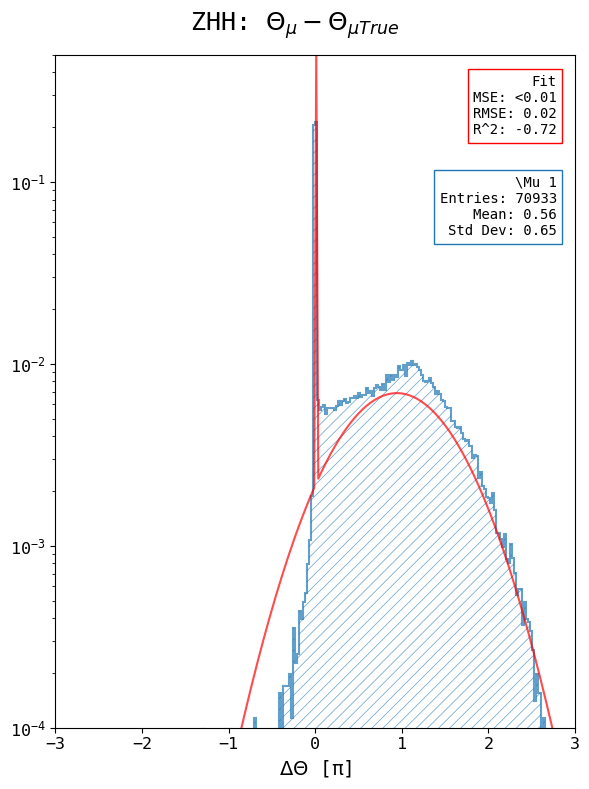

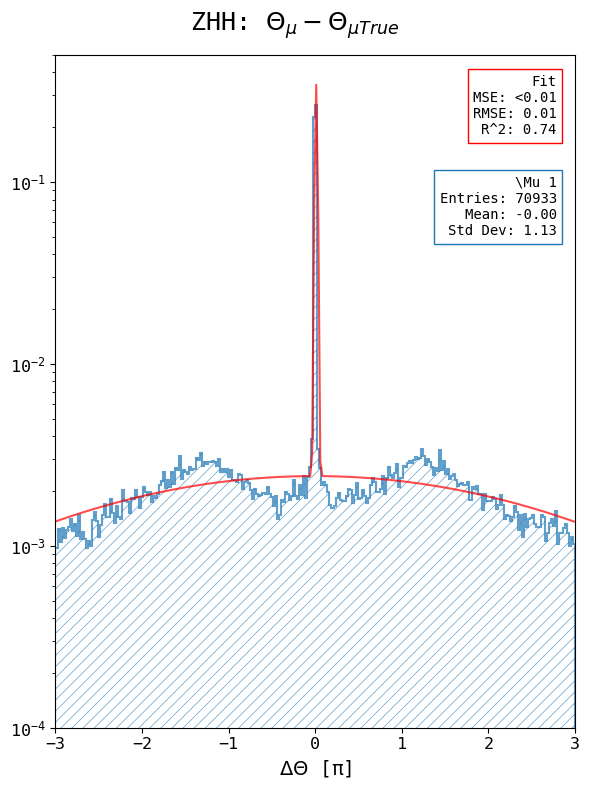

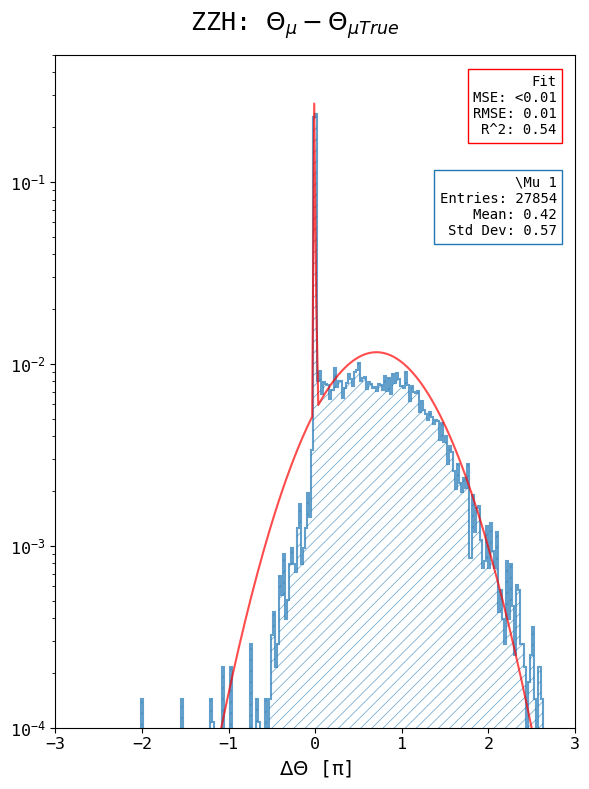

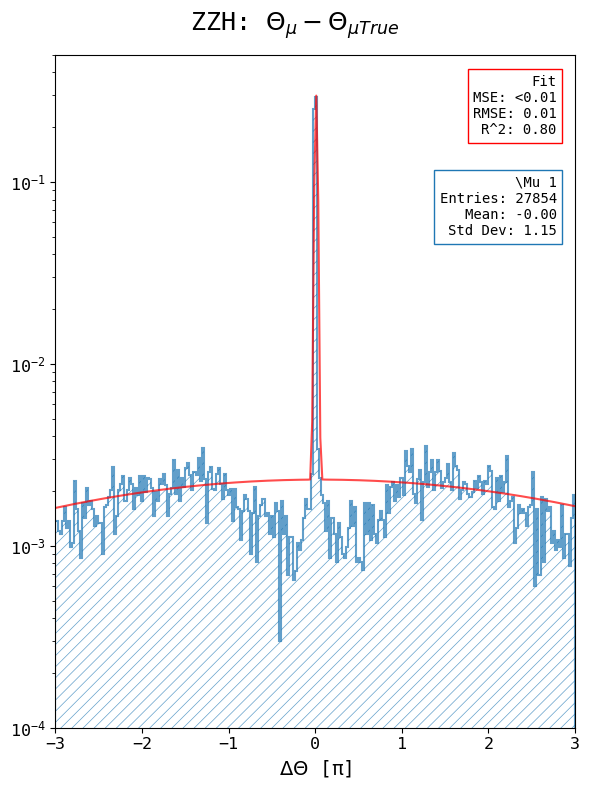

In [128]:
fit = "dbgauss_old"
figures = []

for key in data:
    df = data[key]
    
    theta = { 'lep': [], 'true_lep': [] }
    phi   = { 'lep': [], 'true_lep': [] }
        
    for i in range(1, 2):
        for ptype in ['lep', 'true_lep']:
            theta[ptype].append(np.arccos(df[f"{ptype}{i}_pz"] / np.sqrt(df[f"{ptype}{i}_px"]**2 + df[f"{ptype}{i}_py"]**2 + df[f"{ptype}{i}_pz"]**2)))
            phi[ptype].append(np.arctan2(df[f"{ptype}{i}_py"], df[f"{ptype}{i}_px"]))
    
    for ptype in ['lep', 'true_lep']:
        theta[ptype] = np.array(theta[ptype]).flatten()
        phi[ptype]   = np.array(phi[ptype]).flatten()
    
    for angle in (theta, phi):
        figures, popts = plot_transfer([(angle['lep'], angle['true_lep'])], f"{key.upper()}", fit="dbgauss_old", quantity=r"\Theta", xlabel=r"$\Delta\Theta$ [π]",
                                    true_label=r"\mu True", reco_label=r"\mu", xlim=(-3,3), ylim=(0.0001, 0.5), n_bins=256, yscale="log", plot_args={ 'scientific_stats': True })

[-0.3447331   1.09560828  0.16402026 -0.63663197 67.53377101]
asd
[-0.96832613  1.30242846  0.16097973 -3.16861622 69.36448358]
asd


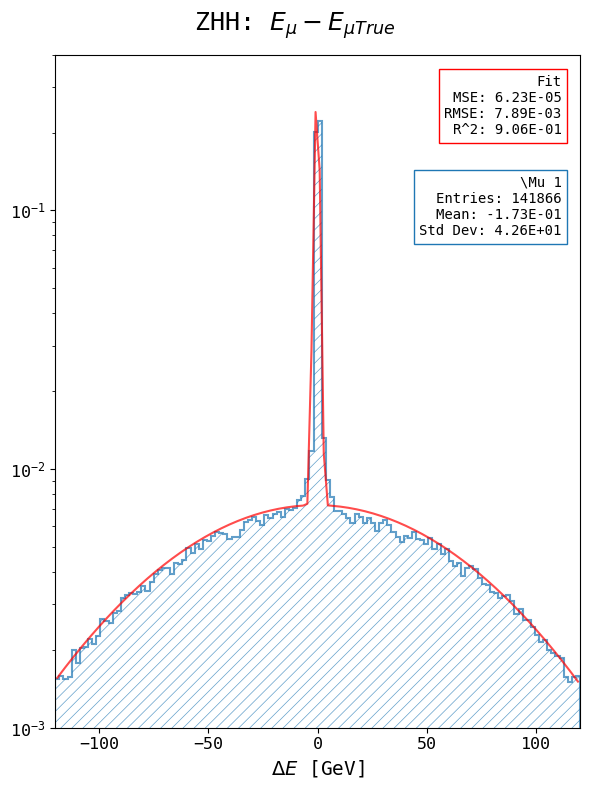

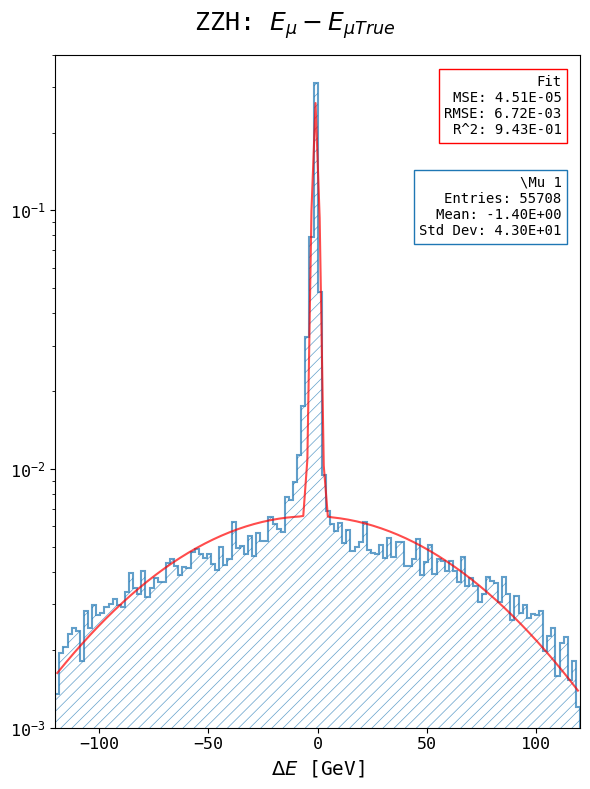

In [119]:
fit = "dbgauss_old"
figures = []
fitparams = []

for key in data:
    df = data[key]
    transfer_data_reco = []
    transfer_data_true = []
    
    for i in range(1, 3):
        transfer_data_reco.append(df[f"lep{i}_e"])
        transfer_data_true.append(df[f"true_lep{i}_e"])
    
    transfer_data_reco = np.array(transfer_data_reco).flatten()
    transfer_data_true = np.array(transfer_data_true).flatten()
    
    fig, popts = plot_transfer([(transfer_data_reco, transfer_data_true)], f"{key.upper()}", fit=fit, xlim=(-120, 120),
                  true_label=r"\mu True", reco_label=r"\mu", ylim=(0.001, 0.4), yscale='log', plot_args={ 'scientific_stats': True });
    
    figures.append(fig[0])
    for popt in popts:
        fitparams.append(popt.tolist())
    
export_figures(f'{repo_dir}/notebooks/results/1_muon_energy.pdf', figures)
with open(f'{repo_dir}/notebooks/results/1_muon_energy_fitparams.txt', 'w', encoding='utf-8') as file:
    json.dump(fitparams, file, ensure_ascii=False, indent=4)

[-0.30563689  1.085674    0.16339704 -0.7247834  67.65512809]
[-0.44422601  1.10127427  0.15999871 -0.51571629 65.94512663]
[-0.11020559  0.74382142  0.14502848 -3.25791045 57.11886863]
[-0.98637278  1.27307875  0.1597308  -3.49016838 69.14259465]


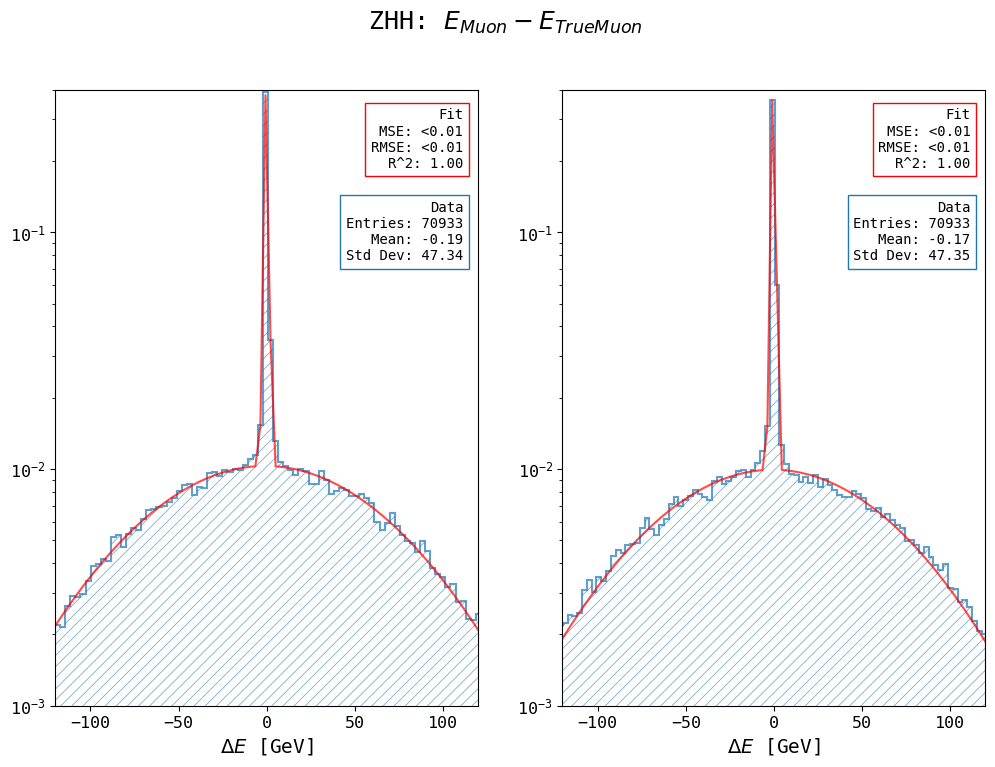

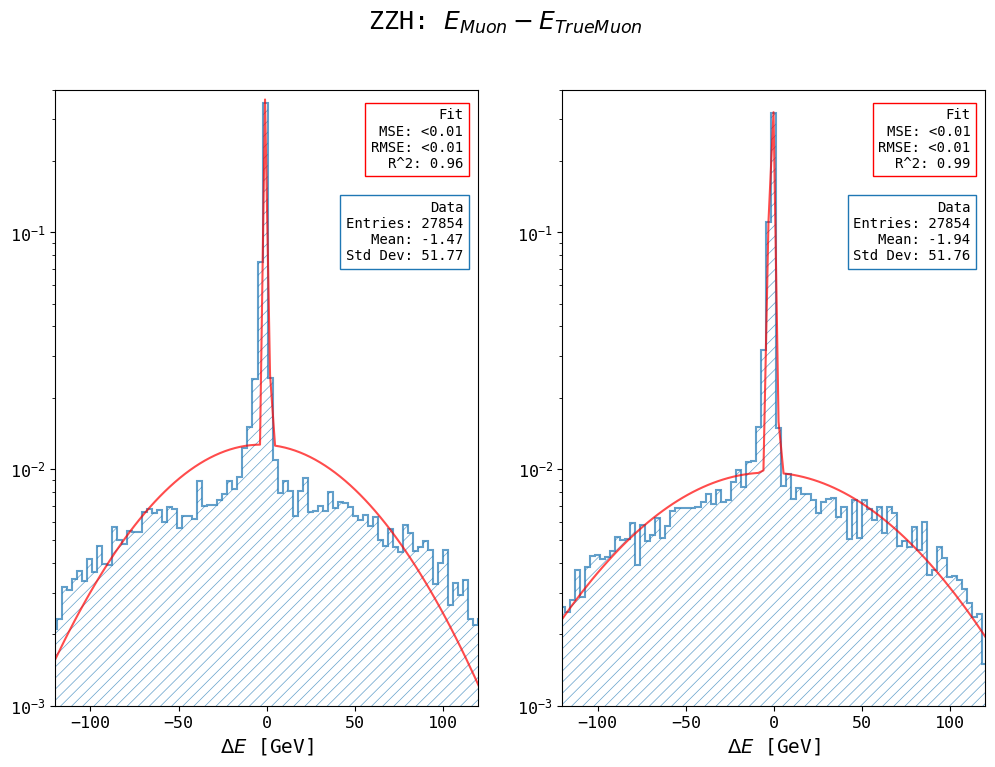

In [97]:
fit = "dbgauss_old"

for key in data:
    transfer_data = []
    df = data[key]
    
    for i in range(1, 3):
        transfer_data.append((df[f"lep{i}_e"], df[f"true_lep{i}_e"]))

    fig, popt = plot_transfer(transfer_data, f"{key.upper()}", fit=fit, true_label="True Muon", reco_label="Muon", fit_init=fit_init, ylim=(0.001, 0.4), xlim=(-120,120), yscale="log");

In [31]:
len(transfer_data_reco)

141866

<Axes: >

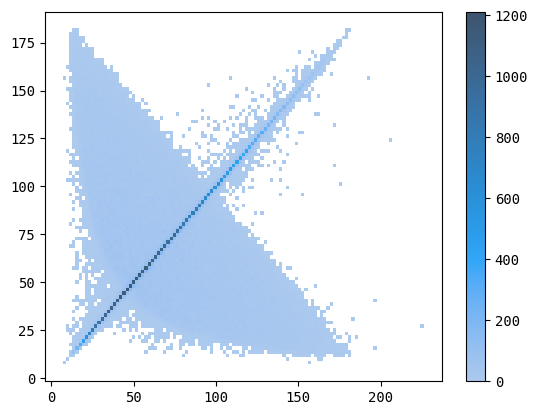

In [30]:
sns.histplot(x=transfer_data_reco, y=transfer_data_true, cbar=True)

In [ ]:
def plot_energy_transfer(data, name, plot_save_dir:Optional[str] = None, fit = "gauss", true_label = "parton", reco_label = "jet"):
    from scipy.optimize import curve_fit
    
    fig, axes = plt.subplots(1, len(data), figsize=(6*len(data),8))
    fig.suptitle(name + r": $E_{" + reco_label + r"}-E_{" + true_label + r"}$", fontsize=18)
    
    for i in range(1,1+len(data)):
        n_bins = 128
        df = data[i-1]
        
        y, bins = np.histogram(df, bins=n_bins)
        x = (bins[:-1] + bins[1:]) / 2
        
        def bw(x, N, x0, G):
            return N*G/((2*pi)*((x-x0)**2 + ((G**2)/4)))
        
        def gauss(x, a, x0, sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))
        
        fit_func = bw if fit == "bw" else gauss
        
        init_bw = [len(df), np.average(df), 1]
        init_gauss = [len(df), np.average(df), np.std(df)]
        
        popt, pcov = curve_fit(fit_func, x, y, p0 = (init_bw if fit_func == bw else init_gauss))

        plot_hist(df, f"{reco_label.title()} {i}", fit_func=lambda x: fit_func(x, *popt), fit_opts=popt, bins=n_bins, xlim=(-100,100), ax=axes[i-1], xlabel=r"$ΔE$ [GeV]", title=f"{reco_label.title()} {i}", normalize=True, yscale="linear")
        #sns.histplot(data["jet{}_e".format(i)] - data["parton{}_e".format(i)], bins=128, ax=axes[i-1]).set_title("Jet {}".format(i))
        
    if plot_save_dir is not None:
        plot_path = osp.join(plot_save_dir, f"{name}.png")
        if osp.isfile(plot_path):
            remove(plot_path)
        
        fig.savefig(plot_path)
    else:
        plt.show()
        
    plt.close(fig)